In [ ]:
!pip install indic-nlp-library
!pip install torch
!pip install torchtext
!pip install spacy
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import os
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/AML_Project/
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/AML_Project"

Mounted at /content/gdrive
/content/gdrive/MyDrive/AML_Project


In [ ]:

import torch
import torchtext
import spacy
from torchtext import data, datasets
from torchtext.vocab import Vectors
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torchtext.datasets import AG_NEWS
from torch.utils.data import Dataset, DataLoader


## Classification Task on Hindi

### Understanding the format of the data

In [ ]:
train_hi = pd.read_csv('/content/gdrive/MyDrive/AML_Project/hi/hi-train.csv', names = ["label", "text"], header=None)
test_hi = pd.read_csv('/content/gdrive/MyDrive/AML_Project/hi/hi-test.csv', names = ["label", "text"], header=None)
train_hi

,label,text
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...
...,...,...
3462,india,जैसे ही उन्हें पता चलता है कि कोई व्यक्ति परेश...
3463,india,जैसे ही सदन की कार्यवाही शुरू हुई तमिलनाडु की ...
3464,news,चीन ने पिछले हफ़्ते अप्रत्यक्ष रूप से भारत को ...
3465,entertainment,मुक्ता आर्ट्स की 'कांची' कहानी है एक ख़ूबसूरत ...


### Building the tokenizer

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer(None) #Can it to different tokenizers among above to experiment

def yield_tokens(df):
  for _, text in df.iterrows():
    yield tokenizer(text[1])

vocab = build_vocab_from_iterator(yield_tokens(train_hi), min_freq = 10, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
#If you don't put min_freq above, the vocab size grows to around million words and the whole
#thing gets quite slow. 

In [ ]:
len(vocab)

10041

In [ ]:
vocab.get_itos()[10:22]

['है', 'पर', 'भी', 'नहीं', 'एक', 'लिए', 'है.', 'कर', 'इस', 'हैं', 'ही', 'तो']

### Storing all the Unique Labels

In [ ]:
# getting all the unique labels and storing it in a dictionaly
a= train_hi["label"].unique()
i = 0
label_dict = {}
while (i< len(a)):
  label_dict[a[i]] = i
  i += 1
label_dict

{'business': 11,
 'china': 7,
 'entertainment': 4,
 'india': 0,
 'institutional': 12,
 'international': 3,
 'learningenglish': 8,
 'multimedia': 13,
 'news': 2,
 'pakistan': 1,
 'science': 6,
 'social': 9,
 'southasia': 10,
 'sport': 5}

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(label_dict[x])

### Creating Custom Datasrt class to make it compatible with Pytorch

In [ ]:
# create custom dataset class
#https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
class CustomTextDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:,0]
        self.text = df.iloc[:,1]
 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx >= self.__len__():
          raise StopIteration
        label = self.labels[idx]
        text = self.text[idx]
        return label, text

In [ ]:
from torch.utils.data.datapipes.iter.utils import IterableWrapperIterDataPipe
from torch.utils.data.datapipes.iter.callable import MapperIterDataPipe
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
      label_list.append(label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = CustomTextDataset(train_hi)
dataloader = DataLoader(train_iter, batch_size=32, shuffle=False, collate_fn=collate_batch)

### Defining the model

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in enumerate(train_iter)]))
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

### Definining the train method



In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

Defining hyperparameters, creating dataloaders, and initiating training

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 15 # 
LR = 2  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
test_iter = CustomTextDataset(test_hi)
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

accuracies_val_mod1=[]
accuracies_train_mod1=[]

for epoch in range(1, EPOCHS + 1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  accuracies_val_mod1.append(accu_val)

  accu_train = evaluate(train_dataloader)
  accuracies_train_mod1.append(accu_train)

  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
      total_accu = accu_val
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'valid accuracy {:8.3f} '.format(epoch,
                                          time.time() - epoch_start_time,
                                          accu_val))
  print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  5.17s | valid accuracy    0.397 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  4.21s | valid accuracy    0.414 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  4.87s | valid accuracy    0.397 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  4.29s | valid accuracy    0.397 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  4.20s | valid accuracy    0.397 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  4.15s |

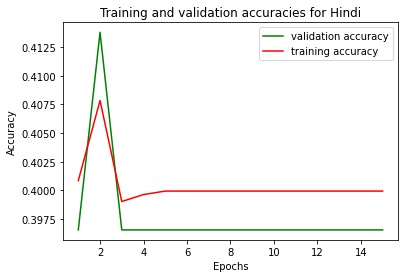

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS+1), accuracies_val_mod1, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod1, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Hindi")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

# Classification Task on Kannada

In [ ]:
train_kn = pd.read_csv('/content/gdrive/MyDrive/AML_Project/kn/kn-train.csv', names = ["label", "text"], header=None)
test_kn = pd.read_csv('/content/gdrive/MyDrive/AML_Project/kn/kn-test.csv', names = ["label", "text"], header=None)
train_kn

,label,text
0,sports,Samsung Galaxy M30s: ಲಭ್ಯವಾಗಲಿದೆ ಶಕ್ತಿಶಾಲಿ ಸ್ಮ...
1,sports,ಯುವೆಂಟಸ್ ತಂಡ ಸೇರಿದ ಕ್ರಿಸ್ಟಿಯಾನೊ ರೊನಾಲ್ಡೊ\nಯುವೆ...
2,sports,"ಬ್ಯಾಡ್ಮಿಂಟನ್‌: ಎರಡನೇ ಸುತ್ತಿಗೆ ಸಿಂಧು, ಸಮೀರ್‌\nಬ..."
3,entertainment,ತಮ್ಮದು ಒಪ್ಪಿತ ʼಸಂಬಂಧʼ ಎಂದು ಹೇಳಿದ ನಟ\n 12-05-2...
4,sports,ಖ್ಯಾತ ಕ್ರಿಕೆಟಿಗನ ಪತ್ನಿ ನಿಧನ\n 31-12-2018 7:57...
...,...,...
23995,sports,ಏಕದಿನ ಕ್ರಿಕೆಟ್‌: ಬ್ಯಾಟಿಂಗ್‌ ಆರಂಭಿಸಿದ ವಿಂಡೀಸ್‌ಗ...
23996,sports,"Chennai, First Published 23, Aug 2019, 10:26 A..."
23997,sports,ಬೆಳ್ಳಿ ಪದಕ ಗೆದ್ದರೂ ಟೀಂಇಂಡಿಯಾ ಹಾಕಿ ಕೋಚ್ ನಿರಾಸೆಗ...
23998,lifestyle,ಸೆನ್ಸಿಟಿವ್ ಹಲ್ಲುಗಳ ಸಮಸ್ಯೆ ಇದೆಯೇ? ಈ ಮನೆಮದ್ದುಗಳನ...


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer(None) #Can it to different tokenizers among above to experiment

def yield_tokens(df):
  for _, text in df.iterrows():
    yield tokenizer(text[1])

vocab = build_vocab_from_iterator(yield_tokens(train_kn), min_freq = 10, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
#If you don't put min_freq above, the vocab size grows to around million words and the whole
#thing gets quite slow. 

In [ ]:
# getting all the unique labels and storing it in a dictionaly
a= train_kn["label"].unique()
i = 0
label_dict = {}
while (i< len(a)):
  label_dict[a[i]] = i
  i += 1
label_dict

{'entertainment': 1, 'lifestyle': 2, 'sports': 0}

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(label_dict[x])

In [ ]:
# create custom dataset class
#https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
class CustomTextDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:,0]
        self.text = df.iloc[:,1]
 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx >= self.__len__():
          raise StopIteration
        label = self.labels[idx]
        text = self.text[idx]
        return label, text

In [ ]:
from torch.utils.data.datapipes.iter.utils import IterableWrapperIterDataPipe
from torch.utils.data.datapipes.iter.callable import MapperIterDataPipe
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
      label_list.append(label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = CustomTextDataset(train_kn)
dataloader = DataLoader(train_iter, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in enumerate(train_iter)]))
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 6 # 
LR = 2  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
test_iter = CustomTextDataset(test_kn)
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

accuracies_val_mod2=[]
accuracies_train_mod2=[]

for epoch in range(1, EPOCHS + 1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  accuracies_val_mod2.append(accu_val)
  accu_train = evaluate(train_dataloader)
  accuracies_train_mod2.append(accu_train)

  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
      total_accu = accu_val
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'valid accuracy {:8.3f} '.format(epoch,
                                          time.time() - epoch_start_time,
                                          accu_val))
  print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time: 43.11s | valid accuracy    0.823 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 41.33s | valid accuracy    0.931 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 41.24s | valid accuracy    0.926 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 41.37s | valid accuracy    0.953 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 41.59s | valid accuracy    0.954 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time: 49.01s |

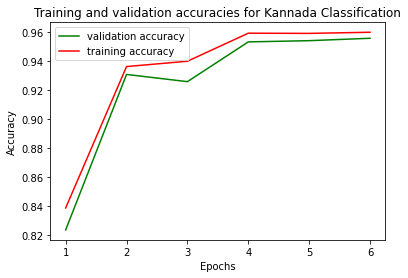

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS+1), accuracies_val_mod2, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod2, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Kannada Classification")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Now we will train on Hindi but only include 3 categories to make it comparable with Kannada

In [ ]:
train_hi = pd.read_csv('/content/gdrive/MyDrive/AML_Project/hi/hi-train.csv', names = ["label", "text"], header=None)
test_hi = pd.read_csv('/content/gdrive/MyDrive/AML_Project/hi/hi-test.csv', names = ["label", "text"], header=None)
train_hi

NameError: ignored

In [ ]:
options = ['entertainment', 'sport', 'business']
train_hi = train_hi[train_hi['label'].isin(options)]
train_hi = train_hi.reset_index()
train_hi.drop(['index'],axis=1, inplace=True)
train_hi

test_hi = test_hi[test_hi['label'].isin(options)]
test_hi = test_hi.reset_index()
test_hi.drop(['index'],axis=1, inplace=True)

NameError: ignored

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer(None) #Can it to different tokenizers among above to experiment

def yield_tokens(df):
  for _, text in df.iterrows():
    yield tokenizer(text[1])

vocab = build_vocab_from_iterator(yield_tokens(train_hi), min_freq = 10, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
#If you don't put min_freq above, the vocab size grows to around million words and the whole
#thing gets quite slow. 

In [ ]:
# getting all the unique labels and storing it in a dictionaly
a= train_hi["label"].unique()
i = 0
label_dict = {}
while (i< len(a)):
  label_dict[a[i]] = i
  i += 1
label_dict

{'business': 2, 'entertainment': 0, 'sport': 1}

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(label_dict[x])

In [ ]:
# create custom dataset class
#https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
class CustomTextDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:,0]
        self.text = df.iloc[:,1]
 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx >= self.__len__():
          raise StopIteration
        label = self.labels[idx]
        text = self.text[idx]
        return label, text

In [ ]:
from torch.utils.data.datapipes.iter.utils import IterableWrapperIterDataPipe
from torch.utils.data.datapipes.iter.callable import MapperIterDataPipe
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
      label_list.append(label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = CustomTextDataset(train_hi)
dataloader = DataLoader(train_iter, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in enumerate(train_iter)]))
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 15 # 
LR = 2  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
test_iter = CustomTextDataset(test_hi)
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

accuracies_val_mod3=[]
accuracies_train_mod3=[]

for epoch in range(1, EPOCHS + 1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  accuracies_val_mod3.append(accu_val)

  accu_train = evaluate(train_dataloader)
  accuracies_train_mod3.append(accu_train)

  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
      total_accu = accu_val
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'valid accuracy {:8.3f} '.format(epoch,
                                          time.time() - epoch_start_time,
                                          accu_val))
  print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  0.61s | valid accuracy    0.467 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.58s | valid accuracy    0.467 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.60s | valid accuracy    0.467 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.58s | valid accuracy    0.467 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.59s | valid accuracy    0.667 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.59s |

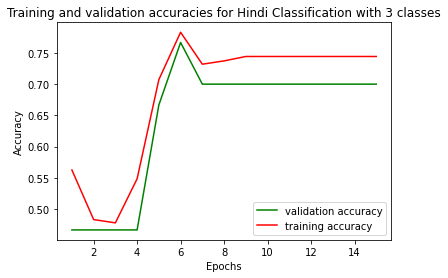

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS+1), accuracies_val_mod3, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod3, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Hindi Classification with 3 classes")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Now we will train for Malayalam

In [ ]:
train_ml = pd.read_csv('/content/gdrive/MyDrive/AML_Project/ml/ml-train.csv', names = ["label", "text"], header=None)
test_ml = pd.read_csv('/content/gdrive/MyDrive/AML_Project/ml/ml-test.csv', names = ["label", "text"], header=None)
train_ml

,label,text
0,sports,മത്സര പ്രതിഫലമായി സ്വന്തമാക്കിയത് പതിനേഴ് ദശലക...
1,sports,ഇന്ത്യൻ പ്രീമിയർ ലീഗിൽ കൊൽക്കത്ത നൈറ്റ് റൈഡേഴ്...
2,entertainment,സിനിമാ മേഖലയിൽ ഇപ്പോൾ ബയോപിക്കുകളുടെ കാലമാണ് ....
3,business,കോഴിയിറച്ചിക്ക് കിലോക്ക് 87രൂപ നിശ്ചയിച്ച സംസ്...
4,sports,ട്വന്റി - 20 ലോകകപ്പിൽ സൂപ്പർ ടെന്നിലെ ഇന്ത്യാ...
...,...,...
4795,business,സ്റ്റേറ്റ് ബാങ്കിൻറെ കറൻസി അഡ്മിനിസ്ട്രേറ്റീവ്...
4796,entertainment,മോഹൻലാൽ നായകനായ ഒടിയൻ എന്ന ചിത്രത്തിന്റ കഥ അമേ...
4797,technology,ജനുവരിയിൽ വാവ്വേ ഇന്ത്യയിൽ അവതരിപ്പിച്ച ഹോണർ 6...
4798,entertainment,തൻറെ ഏറ്റവും പുതിയ ചിത്രം സീറോയുടെ തിരക്കിലാണ്...


In [ ]:
options = ['entertainment', 'sports', 'business']
train_ml = train_ml[train_ml['label'].isin(options)]
train_ml = train_ml.reset_index()
train_ml.drop(['index'],axis=1, inplace=True)
train_ml

test_ml = test_ml[test_ml['label'].isin(options)]
test_ml = test_ml.reset_index()
test_ml.drop(['index'],axis=1, inplace=True)

train_ml

,label,text
0,sports,മത്സര പ്രതിഫലമായി സ്വന്തമാക്കിയത് പതിനേഴ് ദശലക...
1,sports,ഇന്ത്യൻ പ്രീമിയർ ലീഗിൽ കൊൽക്കത്ത നൈറ്റ് റൈഡേഴ്...
2,entertainment,സിനിമാ മേഖലയിൽ ഇപ്പോൾ ബയോപിക്കുകളുടെ കാലമാണ് ....
3,business,കോഴിയിറച്ചിക്ക് കിലോക്ക് 87രൂപ നിശ്ചയിച്ച സംസ്...
4,sports,ട്വന്റി - 20 ലോകകപ്പിൽ സൂപ്പർ ടെന്നിലെ ഇന്ത്യാ...
...,...,...
3597,business,കാപ്പിയുടെ കാര്യത്തിൽ സ്റ്റാർബാക്സിൻറെ പാരമ്പര...
3598,business,സ്റ്റേറ്റ് ബാങ്കിൻറെ കറൻസി അഡ്മിനിസ്ട്രേറ്റീവ്...
3599,entertainment,മോഹൻലാൽ നായകനായ ഒടിയൻ എന്ന ചിത്രത്തിന്റ കഥ അമേ...
3600,entertainment,തൻറെ ഏറ്റവും പുതിയ ചിത്രം സീറോയുടെ തിരക്കിലാണ്...


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer(None) #Can it to different tokenizers among above to experiment

def yield_tokens(df):
  for _, text in df.iterrows():
    yield tokenizer(text[1])

vocab = build_vocab_from_iterator(yield_tokens(train_ml), min_freq = 10, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
#If you don't put min_freq above, the vocab size grows to around million words and the whole
#thing gets quite slow. 

In [ ]:
# getting all the unique labels and storing it in a dictionaly
a= train_ml["label"].unique()
i = 0
label_dict = {}
while (i< len(a)):
  label_dict[a[i]] = i
  i += 1
label_dict

{'business': 2, 'entertainment': 1, 'sports': 0}

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(label_dict[x])

In [ ]:
# create custom dataset class
#https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
class CustomTextDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:,0]
        self.text = df.iloc[:,1]
 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx >= self.__len__():
          raise StopIteration
        label = self.labels[idx]
        text = self.text[idx]
        return label, text

In [ ]:
from torch.utils.data.datapipes.iter.utils import IterableWrapperIterDataPipe
from torch.utils.data.datapipes.iter.callable import MapperIterDataPipe
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
      label_list.append(label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = CustomTextDataset(train_ml)
dataloader = DataLoader(train_iter, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in enumerate(train_iter)]))
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 15 # 
LR = 2  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
test_iter = CustomTextDataset(test_ml)
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

accuracies_val_ml=[]
accuracies_train_ml=[]

for epoch in range(1, EPOCHS + 1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  accuracies_val_ml.append(accu_val)

  accu_train = evaluate(train_dataloader)
  accuracies_train_ml.append(accu_train)

  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
      total_accu = accu_val
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'valid accuracy {:8.3f} '.format(epoch,
                                          time.time() - epoch_start_time,
                                          accu_val))
  print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  2.10s | valid accuracy    0.398 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  2.73s | valid accuracy    0.420 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  3.64s | valid accuracy    0.453 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  3.14s | valid accuracy    0.525 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  2.03s | valid accuracy    0.575 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  2.02s |

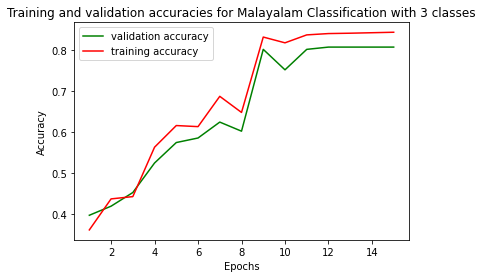

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS+1), accuracies_val_ml, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_ml, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Malayalam Classification with 3 classes")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()